In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
import qiskit

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
from qiskit import IBMQ
from qiskit.compiler import transpile
from time import perf_counter
from qiskit.tools.visualization import plot_histogram

import numpy as np
import math

'''
params
---------------
picture: square 2d array of integers representing grayscale values
assume the length (n) is some power of 2

return
---------------
a flattened representation of picture using bitstrings (boolean arrays)
'''
def convert_to_bits (picture):
    n = len(picture)
    ret = []
    for i in range(n):
        for j in range(n):
            value = picture[i][j]
            bitstring = bin(value)[2:]
            ret.append([0 for i in range(8 - len(bitstring))] + [1 if c=='1' else 0 for c in bitstring])
    return ret

'''
params
----------------
bitStr: a representation of an image using bitstrings to represent grayscale values

return
----------------
A quantum circuit containing the NEQR representation of the image
'''
def neqr(bitStr): 
    newBitStr = bitStr

    #print(newBitStr)
    #print("\n")

    # Pixel position
    idx = QuantumRegister(math.ceil(math.log2(len(newBitStr))), 'idx')

    # Pixel intensity values
    intensity = QuantumRegister(8, 'intensity')

    # Classical Register
    creg = ClassicalRegister(10, 'creg')

    # Quantum Image Representation as a quantum circuit
    # with Pixel Position and Intensity registers
    quantumImage = QuantumCircuit(intensity, idx, creg)

    numOfQubits = quantumImage.num_qubits
    print("\n>> Initial Number of Qubits:", numOfQubits)

    # -----------------------------------
    # Drawing the Quantum Circuit
    # -----------------------------------
    lengthIntensity = intensity.size
    lengthIdx = idx.size

    start = perf_counter()

    quantumImage.i([intensity[lengthIntensity-1-i] for i in range(lengthIntensity)])
    quantumImage.h([idx[lengthIdx-1-i] for i in range(lengthIdx)])

    numOfPixels = len(newBitStr)

    for i in range(numOfPixels):
        bin_ind = bin(i)[2:]
        bin_ind = (lengthIdx - len(bin_ind)) * '0' + bin_ind
        bin_ind = bin_ind[::-1]

        # X-gate (enabling zero-controlled nature)
        for j in range(len(bin_ind)):
            if bin_ind[j] == '0':
                quantumImage.x(idx[j])

        # Configuring Multi-Qubit Controlled-NOT (mcx) gates with control and target qubits
        for j in range(len(newBitStr[i])):
            if newBitStr[i][j] == 1:
                quantumImage.mcx(idx, intensity[lengthIntensity-1-j])
        
        # X-gate (reversing the Negated state of the qubits)
        for j in range(len(bin_ind)):
            if bin_ind[j] == '0':
                quantumImage.x(idx[j])
        
        quantumImage.barrier()

    quantumImage.measure(range(10), range(10))

    end = perf_counter()
    print(f">> Circuit construction took {(end-start)} seconds.")

    return (quantumImage, intensity)

if __name__ == '__main__':
    test_picture_2x2 = [[0, 100], [200, 255]]
    test_picture_3x3 = [[25, 50, 75], [100, 125, 150], [175, 200, 225]]
    test_picture_4x4 = [[0, 100, 143, 83], [200, 255, 43, 22], [12, 234, 23, 5], [112, 113, 117, 125]]
    test_picture_5x5 = [[0, 100, 212, 12, 32], [0, 100, 212, 12, 32], [0, 100, 212, 12, 32], [0, 100, 212, 12, 32], [0, 100, 212, 12, 32]]
    
    arr = convert_to_bits(test_picture_2x2)
    arr1 = convert_to_bits(test_picture_3x3)
    arr2 = convert_to_bits(test_picture_4x4)
    arr3 = convert_to_bits(test_picture_5x5)
    
    print("2x2: ", arr, "\n") 
    #print("3x3: ", arr1, "\n") 
    #print("4x4: ", arr2, "\n") 
    #print("5x5: ", arr3, "\n") 
    
    qc_image, _ = neqr(arr)

2x2:  [[0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 1, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1]] 


>> Initial Number of Qubits: 10
>> Circuit construction took 0.0019276831299066544 seconds.


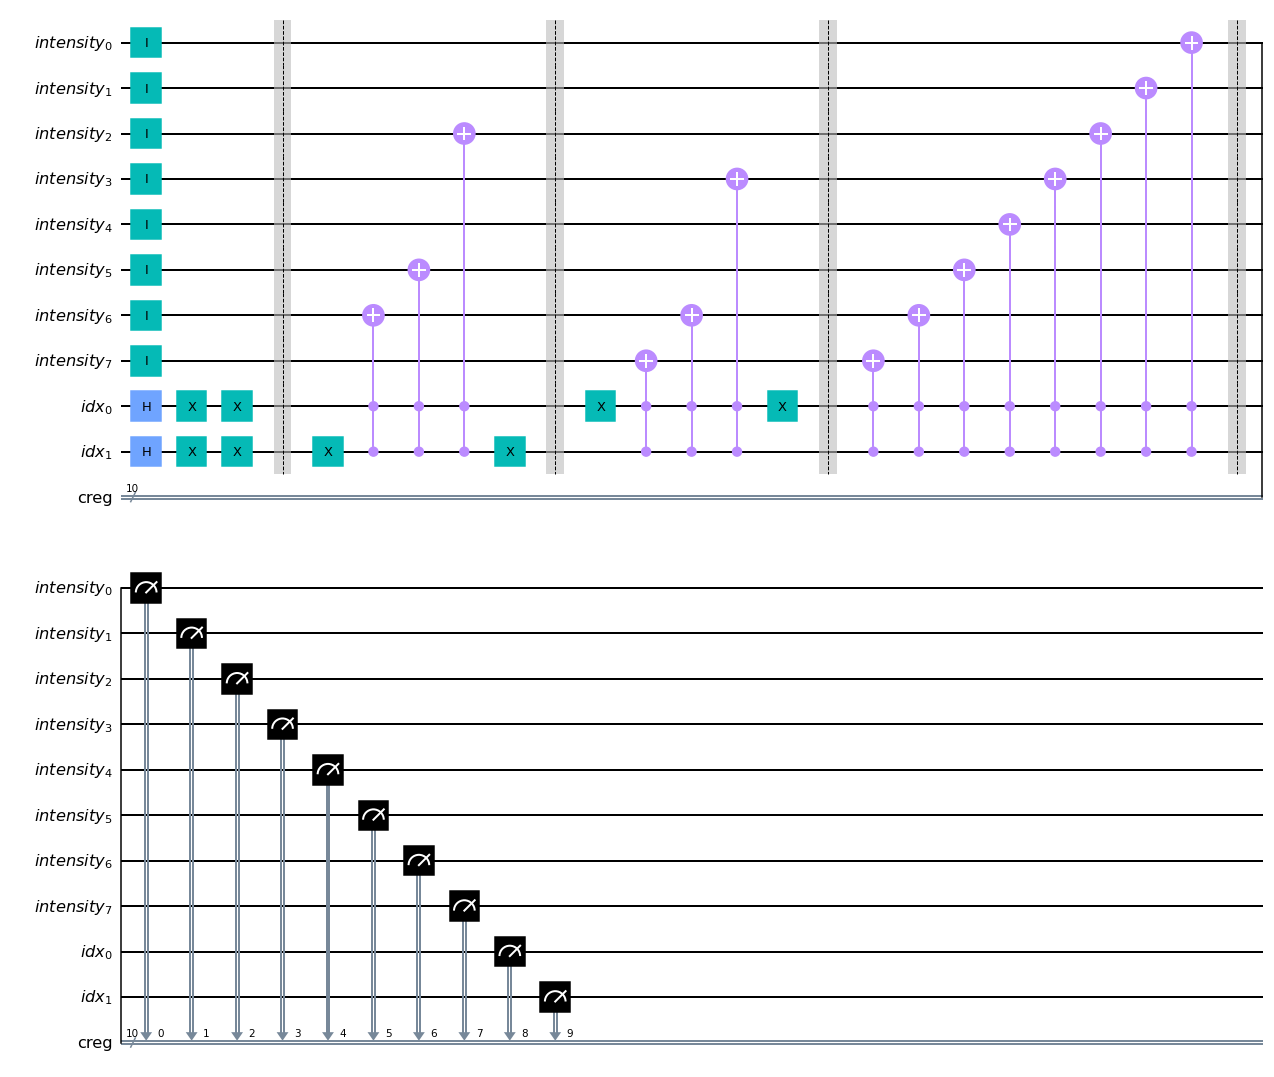

In [3]:
qc_image.draw()

In [29]:
# Circuit Dimensions  
print('>> Circuit dimensions')
print('>> Circuit depth (length of critical path): ', qc_image.depth())
print('>> Total Number of Gate Operations: ', qc_image.size())

# Get the number of qubits needed to run the circuit
active_qubits = {}
for op in qc_image.data:
    if op[0].name != "barrier" and op[0].name != "snapshot":
        for qubit in op[1]:
            active_qubits[qubit.index] = True
print(f">> Width: {len(active_qubits)} qubits")
print(f">> Width (total number of qubits and clbits): {qc_image.width()} qubits")

print(f">> Gates used: {qc_image.count_ops()}")
print(f">> Fundamental Gates: {qc_image.decompose().count_ops()}")

# Testing qc_image circuit using Fake Simulator 
# to simulate the error in a real quantum computer
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeMontreal
device_backend = FakeMontreal()
sim_montreal = AerSimulator.from_backend(device_backend)

#### TRANSPILING
start_transpile = perf_counter()
tcirc = transpile(qc_image, sim_montreal, optimization_level=1) # Optimization Level = 1 (default)
end_transpile = perf_counter()
print(f"\n>> Circuit transpilation took {(end_transpile-start_transpile)} seconds.")

#### SIMULATING
start_sim = perf_counter()
# Run transpiled circuit on FakeMontreal 
result_noise = sim_montreal.run(tcirc).result()
# Get counts for each possible result 
counts_noise = result_noise.get_counts()
end_sim = perf_counter()
print(f"\n>> Circuit simulation took {(end_sim-start_sim)} seconds.")

>> Circuit dimensions
>> Circuit depth (length of critical path):  22
>> Total Number of Gate Operations:  42
>> Width: 8 qubits
>> Width (total number of qubits and clbits): 20 qubits
>> Gates used: OrderedDict([('ccx', 14), ('measure', 10), ('id', 8), ('x', 8), ('barrier', 4), ('h', 2)])
>> Fundamental Gates: OrderedDict([('cx', 84), ('t', 56), ('tdg', 42), ('h', 28), ('measure', 10), ('id', 8), ('u3', 8), ('barrier', 4), ('u2', 2)])


<ipython-input-29-6adc6dc425c9>:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  active_qubits[qubit.index] = True



>> Circuit transpilation took 0.3181125510018319 seconds.

>> Circuit simulation took 10.941384928999469 seconds.


In [30]:
#plot_histogram(counts_noise, figsize=(30, 15))
#print(counts_noise)

{'0111101110': 1, '1110111110': 1, '0000010101': 1, '0001101110': 1, '1110000001': 1, '0010010011': 1, '0110100100': 1, '1101111110': 1, '1001010000': 1, '0010100010': 1, '0111010001': 1, '1000000100': 1, '1010000111': 1, '1000101100': 1, '0010110000': 1, '0101001110': 1, '0110011000': 1, '0000001110': 2, '1011011110': 1, '1011110011': 1, '0011000101': 1, '0101100110': 1, '1001001101': 1, '1000110101': 1, '1111001111': 2, '1111000011': 1, '0111100100': 6, '1110011011': 6, '0100000010': 2, '0111110000': 2, '1010010000': 2, '1010100110': 1, '1100101100': 1, '1001101110': 1, '0111101010': 1, '0000110100': 2, '0000001001': 1, '1010001001': 2, '0011001000': 12, '0010011000': 4, '0000100000': 3, '1100101011': 2, '1011010100': 1, '1001001100': 1, '0010001000': 10, '1010110000': 1, '0111001000': 6, '0100000100': 3, '0011101001': 1, '1011000100': 1, '1100000100': 1, '1001000001': 1, '0010100000': 3, '0100111000': 4, '0011101100': 2, '0111001100': 2, '1100110111': 4, '1001010010': 1, '1011100100

Encoded: 00 =  [0, 0, 0, 0, 0, 0, 0, 0]
Encoded: 01 =  [0, 1, 1, 0, 0, 1, 0, 0]
Encoded: 10 =  [1, 1, 0, 0, 1, 0, 0, 0]
Encoded: 11 =  [1, 1, 1, 1, 1, 1, 1, 1]

Expected Counts per pixel =  256.0
Experimental Counts {'0000000000': 249, '1011001000': 245, '0101100100': 250, '1111111111': 280}

Expected probability for each pixel =  0.25


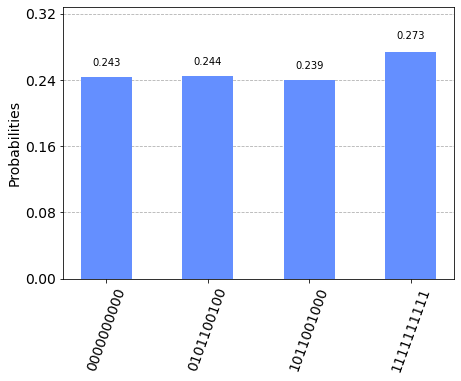

In [11]:
from qiskit.compiler import assemble
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)

shots = 1024

qobj = assemble(t_qc_image, shots=shots)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
print('Encoded: 00 = ', arr[0])
print('Encoded: 01 = ', arr[1])
print('Encoded: 10 = ', arr[2])
print('Encoded: 11 = ', arr[3])

print("\nExpected Counts per pixel = ", shots/len(arr))
print("Experimental Counts", counts_neqr)
print("\nExpected probability for each pixel = ", 1.0/(len(arr)))
plot_histogram(counts_neqr)

In [55]:
machine = "ibmq_santiago"
backend = provider.get_backend(machine)
santiago_sim = AerSimulator.from_backend(backend)
start_sim = perf_counter()
result = santiago_sim.run(qc_image).result()
counts = result.get_counts(qc_image)
end_sim = perf_counter()
print("\n", end_sim-start_sim)
print("\nExpected Counts per pixel = ", shots/len(arr), "\n")
for(measured_state, count) in counts.items():
    big_endian_state = measured_state[::-1]
    print(f"Measured {big_endian_state} {count} times.")


 0.1754909169394523

Expected Counts per pixel =  256.0 

Measured 0101101101 1 times.
Measured 1000000000 1 times.
Measured 1001001101 4 times.
Measured 1011111111 5 times.
Measured 0010111010 1 times.
Measured 0001001101 208 times.
Measured 0000000000 223 times.
Measured 0001101101 2 times.
Measured 1111111111 254 times.
Measured 0000011010 4 times.
Measured 0100000000 29 times.
Measured 1111011111 2 times.
Measured 0000100000 1 times.
Measured 0101001101 21 times.
Measured 0010011010 216 times.
Measured 1110111111 2 times.
Measured 0110011010 23 times.
Measured 0111111111 14 times.
Measured 0011001101 3 times.
Measured 0000001101 4 times.
Measured 1010011010 4 times.
Measured 1101111111 2 times.


In [53]:
machine = "ibmq_belem"
backend = provider.get_backend(machine)
santiago_sim = AerSimulator.from_backend(backend)
start_sim = perf_counter()
result = santiago_sim.run(qc_image).result()
counts = result.get_counts(qc_image)
end_sim = perf_counter()
print(end_sim-start_sim)
print("\nExpected Counts per pixel = ", shots/len(arr), "\n")
for(measured_state, count) in counts.items():
    big_endian_state = measured_state[::-1]
    print(f"Measured {big_endian_state} {count} times.")

0.15855370298959315

Expected Counts per pixel =  256.0 

Measured 0010000000 1 times.
Measured 1001111111 1 times.
Measured 1110011010 1 times.
Measured 0011101101 1 times.
Measured 0001101101 2 times.
Measured 1011111111 6 times.
Measured 1111011111 5 times.
Measured 0000100000 3 times.
Measured 0111111111 9 times.
Measured 1111111111 216 times.
Measured 0000011010 11 times.
Measured 0010111010 3 times.
Measured 1001001101 3 times.
Measured 0001000000 1 times.
Measured 0001001101 238 times.
Measured 0000000000 235 times.
Measured 1110111111 9 times.
Measured 0010011010 249 times.
Measured 0011011010 3 times.
Measured 1000000000 2 times.
Measured 0011001101 4 times.
Measured 0000001101 7 times.
Measured 1101111111 9 times.
Measured 1010011010 2 times.
Measured 0100000000 3 times.


In [42]:
# Testing qc_image circuit using Fake Simulator 
# to simulate the error in a real quantum computer
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeMumbai
device_backend = FakeMumbai()
sim_brooklyn = AerSimulator.from_backend(device_backend)

#### TRANSPILING
start_transpile = perf_counter()
tcirc = transpile(qc_image, sim_brooklyn, optimization_level=1) # Optimization Level = 1 (default)
end_transpile = perf_counter()
print(f"\n>> Circuit transpilation took {(end_transpile-start_transpile)} seconds.")

#### SIMULATING
start_sim = perf_counter()
# Run transpiled circuit on FakeMontreal 
result_noise = sim_brooklyn.run(tcirc).result()
# Get counts for each possible result 
counts_noise = result_noise.get_counts()
end_sim = perf_counter()
print(f"\n>> Circuit simulation took {(end_sim-start_sim)} seconds.")


>> Circuit transpilation took 0.5931568020023406 seconds.

>> Circuit simulation took 2.681878018891439 seconds.


{'0000101011': 1, '1000001110': 1, '1110001101': 1, '1101001010': 1, '1110101110': 1, '0000000111': 1, '0010101110': 1, '0001010100': 3, '1010111111': 1, '0100110010': 1, '0011000001': 1, '0111011111': 1, '1001011100': 1, '0011010010': 1, '1001011111': 1, '0011010110': 1, '1111100010': 1, '1000000011': 1, '1011110010': 3, '1110010001': 1, '0111010010': 1, '1101011100': 1, '0100101111': 1, '0010110001': 1, '1001010010': 1, '0100010111': 1, '0111010001': 1, '0001110010': 1, '1000101101': 1, '1111010110': 1, '1101010101': 1, '1000110101': 1, '1000110000': 3, '1010000101': 1, '0100010110': 1, '0100100001': 2, '0110010100': 1, '1001110111': 1, '0111111001': 1, '1110101010': 2, '1011010010': 2, '1011010111': 2, '1100100001': 1, '0101101010': 3, '0011110110': 2, '0000111010': 1, '1000110110': 2, '0111010110': 2, '0010101010': 1, '0101110110': 3, '0100111111': 1, '1011000101': 2, '1010111011': 1, '1101000100': 1, '0110000111': 1, '1101000001': 2, '0100010101': 1, '1100100000': 1, '0000100001':

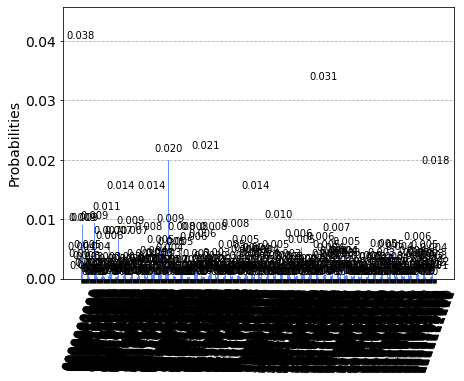

In [59]:
from qiskit.test.mock import FakeMontreal
fake_athens = FakeMontreal()
t_qc = transpile(qc_image, fake_athens, optimization_level=3)
qobj = assemble(t_qc, shots=4096)
result = fake_athens.run(qobj).result()
counts = result.get_counts(qc_image)
print(counts)
plot_histogram(counts)

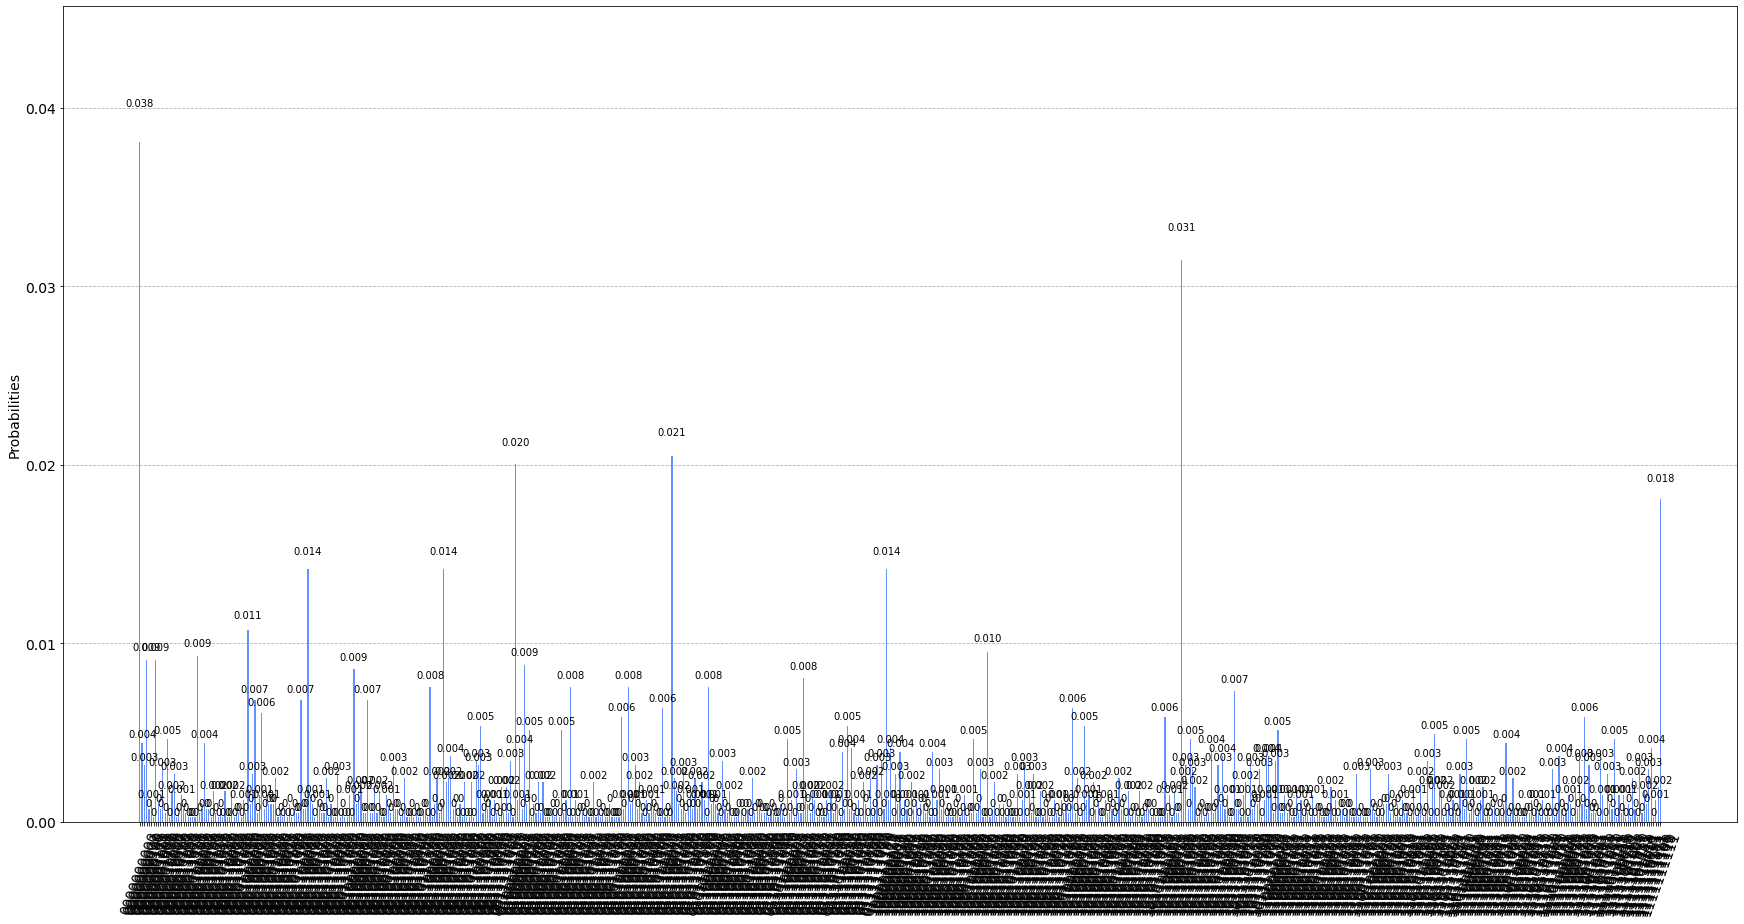

In [61]:
plot_histogram(counts, figsize=(30, 15))